# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
#%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 47.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib: filename=matplotlib-3.7.1-cp312-cp312-linux_x86_64.whl size=11048416 sha256=7d84b607dbae676dc63357558ea9002a2a8713378c69aa772d121d4a552b38c9
  Stored in directory: /home/baldasseroniluisesteban/.cache/pip/wheels/1c/06/fa/3453aac11411fac092c1bdfe52815f2f6969a42700d977e62f
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.2
    Uninstalling matplotlib-3.9.2:
      Successfully uninstalled matplotlib-3.9.2

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: optuna
    Found existing installation: optuna 4.0.0
    Uninstalling o

In [2]:
! pip install "dask[dataframe]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

Matplotlib is building the font cache; this may take a moment.


/home/baldasseroniluisesteban/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
base_path = '/home/baldasseroniluisesteban/buckets/b1/'
dataset_path = base_path + 'datasets/'
dataset_file = 'competencia_02_sin_nulos.csv.gz'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train_inicio = 201901
mes_train_final = 202104
mes_test = 202106

# agregue sus semillas
semillas = [127,181,13]


data = pd.read_csv(dataset_path + dataset_file)

In [5]:
data.drop(columns=['clase_ternaria_lag_1', 'clase_ternaria_lag_2', 'clase_ternaria_lag_3',
                   'clase_ternaria_lag_6', 'clase_ternaria_lag_12'], inplace=True)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [6]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [7]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [8]:
train_data = data[(mes_train_inicio <= data['foto_mes']) & (data['foto_mes'] <= mes_train_final)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Y preparamos el *dataset* para poder usar el **rf** de una clase anterior.

In [9]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# Xif = imp_mean.fit_transform(X_test)

Comenzaremos explicando el funcionamiento del protagonista de esta clase: **LightGBM**. Primero, partiremos con una revisión de cómo funciona el algoritmo en el que se basa, **XGBoost**. Para una introducción completa, puedes consultar este

https://xgboost.readthedocs.io/en/stable/tutorials/model.html.

Aunque en la cátedra no somos grandes seguidores de Josh Starmer y su canal *StatQuest*, reconozco que sus series sobre *Gradient Boosting* y *XGBoost* son excelentes recursos. Aquí te dejamos los enlaces a esas dos series que realmente valen la pena:

[Serie Gradient Boosting](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

[Serie XGBoost](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ)

Finalmente, analizaremos las diferencias clave que ofrece **LightGBM** frente a XGBoost. Puedes explorar más sobre ello en este https://lightgbm.readthedocs.io/en/stable/Features.html.

No olvides tener a mano la [documentación de LightGBM](https://lightgbm.readthedocs.io/)y la [lista completa de sus parámetros](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

Este es un algoritmo muy usado en el mercado, recomiendo dedicarle el tiempo necesario para aprenderlo bien.

Vamos a utilizar el algoritmo directamente, sin pasar por *scikit-learn*. Sin embargo, si algún alumno lo prefiere, puede optar por usar el *wrapper* de sklearn para este caso.

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [10]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [11]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv** que viene *out-of-the-box*

In [12]:
# cv_results1 = lgb.cv(
#     params,
#     train_data1,
#     num_boost_round=150,
#     feval=lgb_gan_eval,
#     nfold=5,
#     seed=semillas[0]
# )

# cv_results2 = lgb.cv(
#     params,
#     train_data2,
#     num_boost_round=150,
#     feval=lgb_gan_eval,
#     nfold=5,
#     seed=semillas[0]
# )

Y vizualizamos los resultados de ambas ejecuciones:

In [13]:
# df_ganancias = pd.DataFrame({
#     'binaria1': cv_results1['valid gan_eval-mean'],
#     'binaria2': cv_results2['valid gan_eval-mean'],
#     'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
# })

# # Normalizamos la ganancias
# df_ganancias['binaria1'] = df_ganancias['binaria1']*5
# df_ganancias['binaria2'] = df_ganancias['binaria2']*5

# plt.figure(figsize=(10, 6))
# sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
# sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
# plt.title('Comparación de las Ganancias de las 2 clases binarias')
# plt.xlabel('Iteración')
# plt.ylabel('Ganancia')
# plt.legend()
# plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos. Dado que cada pequeña mejora es importante, continuaremos utilizando esta estrategia.

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**. Cabe destacar que las optimizaciones que realizaremos son básicas y están diseñadas para ejecutarse en pocos minutos. Será su responsabilidad ampliar tanto el rango de búsqueda como el tiempo de optimización para obtener un modelo más competitivo.


In [14]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 1000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.3, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.3, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 100)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 300)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'max_depth': max_depth,
        'bagging_freq': bagging_freq,
        'seed': semillas[0],
        'verbose': -1,
        'early_stopping' :30,
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)

    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=50,
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )





    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + dataset_path + "optimization_lgbm_lags.db"
study_name = "exp_201_lgbm_lags"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-11-18 17:27:33,806] Using an existing study with name 'exp_201_lgbm_lags' instead of creating a new one.


In [15]:
study.optimize(objective, n_trials=10) # subir subir

[I 2024-11-18 17:37:07,208] Trial 20 finished with value: 35435911000.0 and parameters: {'num_leaves': 331, 'learning_rate': 0.13502160392872262, 'min_data_in_leaf': 864, 'feature_fraction': 0.7869512336549254, 'bagging_fraction': 0.8100118324592905, 'max_depth': 52, 'bagging_freq': 133}. Best is trial 11 with value: 35498421000.0.
[I 2024-11-18 17:47:44,521] Trial 21 finished with value: 35478730000.0 and parameters: {'num_leaves': 458, 'learning_rate': 0.14891068632623405, 'min_data_in_leaf': 782, 'feature_fraction': 0.9953529871624489, 'bagging_fraction': 0.9405561182972092, 'max_depth': 76, 'bagging_freq': 11}. Best is trial 11 with value: 35498421000.0.
[I 2024-11-18 17:58:11,419] Trial 22 finished with value: 35483294000.0 and parameters: {'num_leaves': 499, 'learning_rate': 0.11507060680514249, 'min_data_in_leaf': 746, 'feature_fraction': 0.8730844593880089, 'bagging_fraction': 0.9339634293582002, 'max_depth': 75, 'bagging_freq': 31}. Best is trial 11 with value: 35498421000.0.


Analizamos los resultados as usual

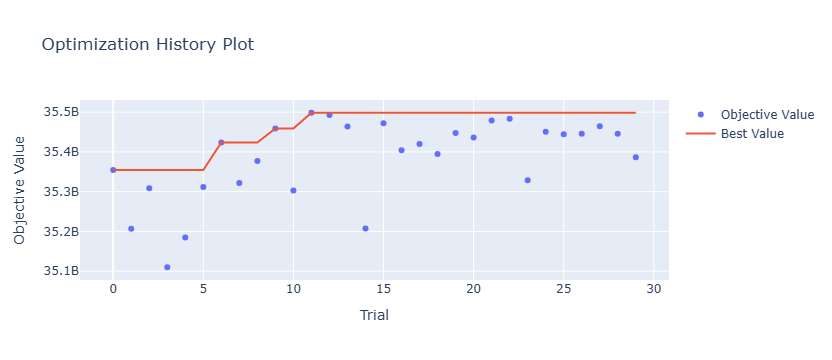

In [16]:
optuna.visualization.plot_optimization_history(study)

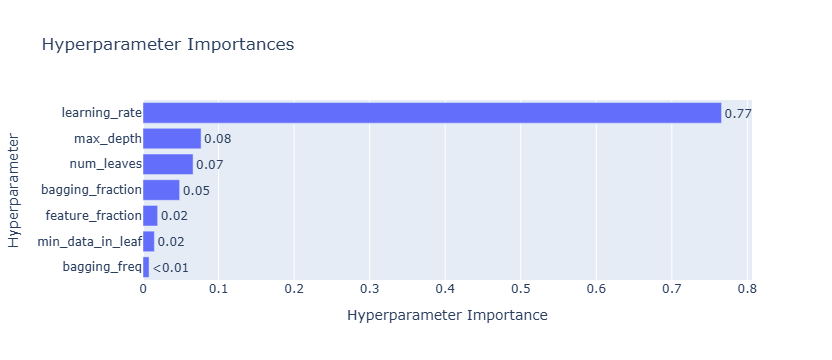

In [17]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

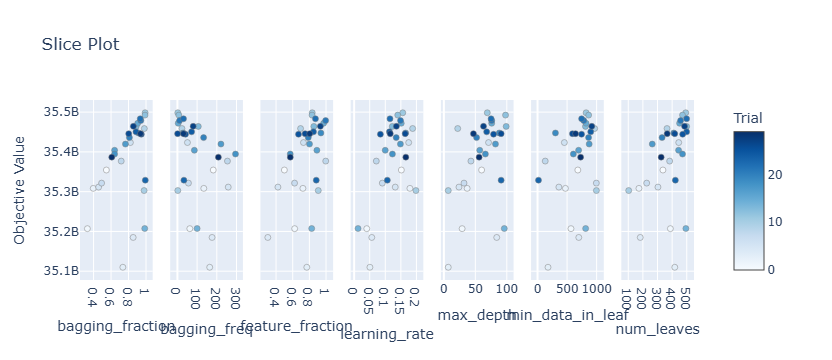

In [18]:
plot_slice(study)

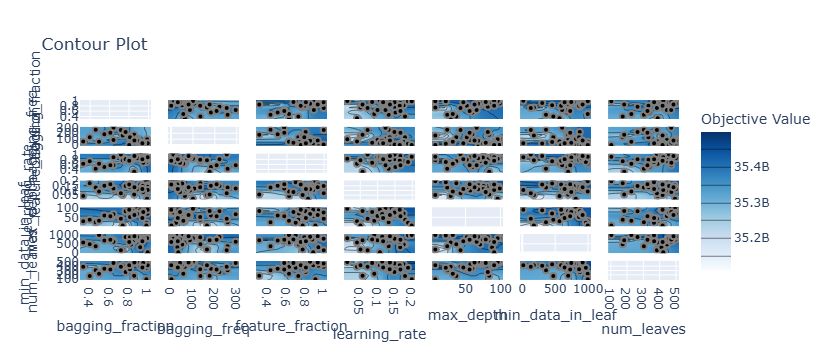

In [19]:
plot_contour(study)

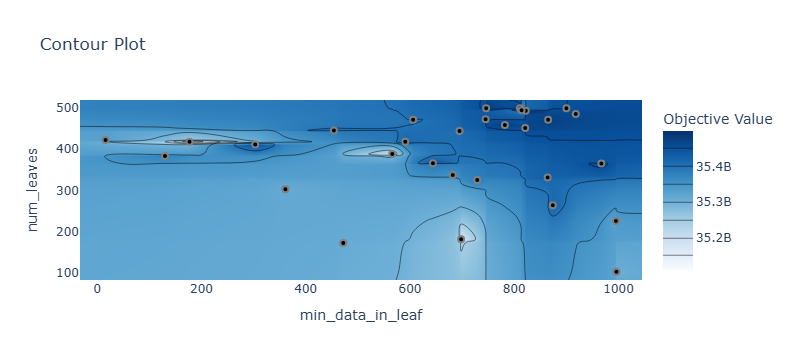

In [20]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [21]:
X_train.foto_mes.unique()

array([202101, 202102, 202103, 202104, 201901, 201902, 201903, 201904,
       201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
       202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
       202009, 202010, 202011, 202012])

In [22]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 50


Observamos la variables más importantes para el modelo:

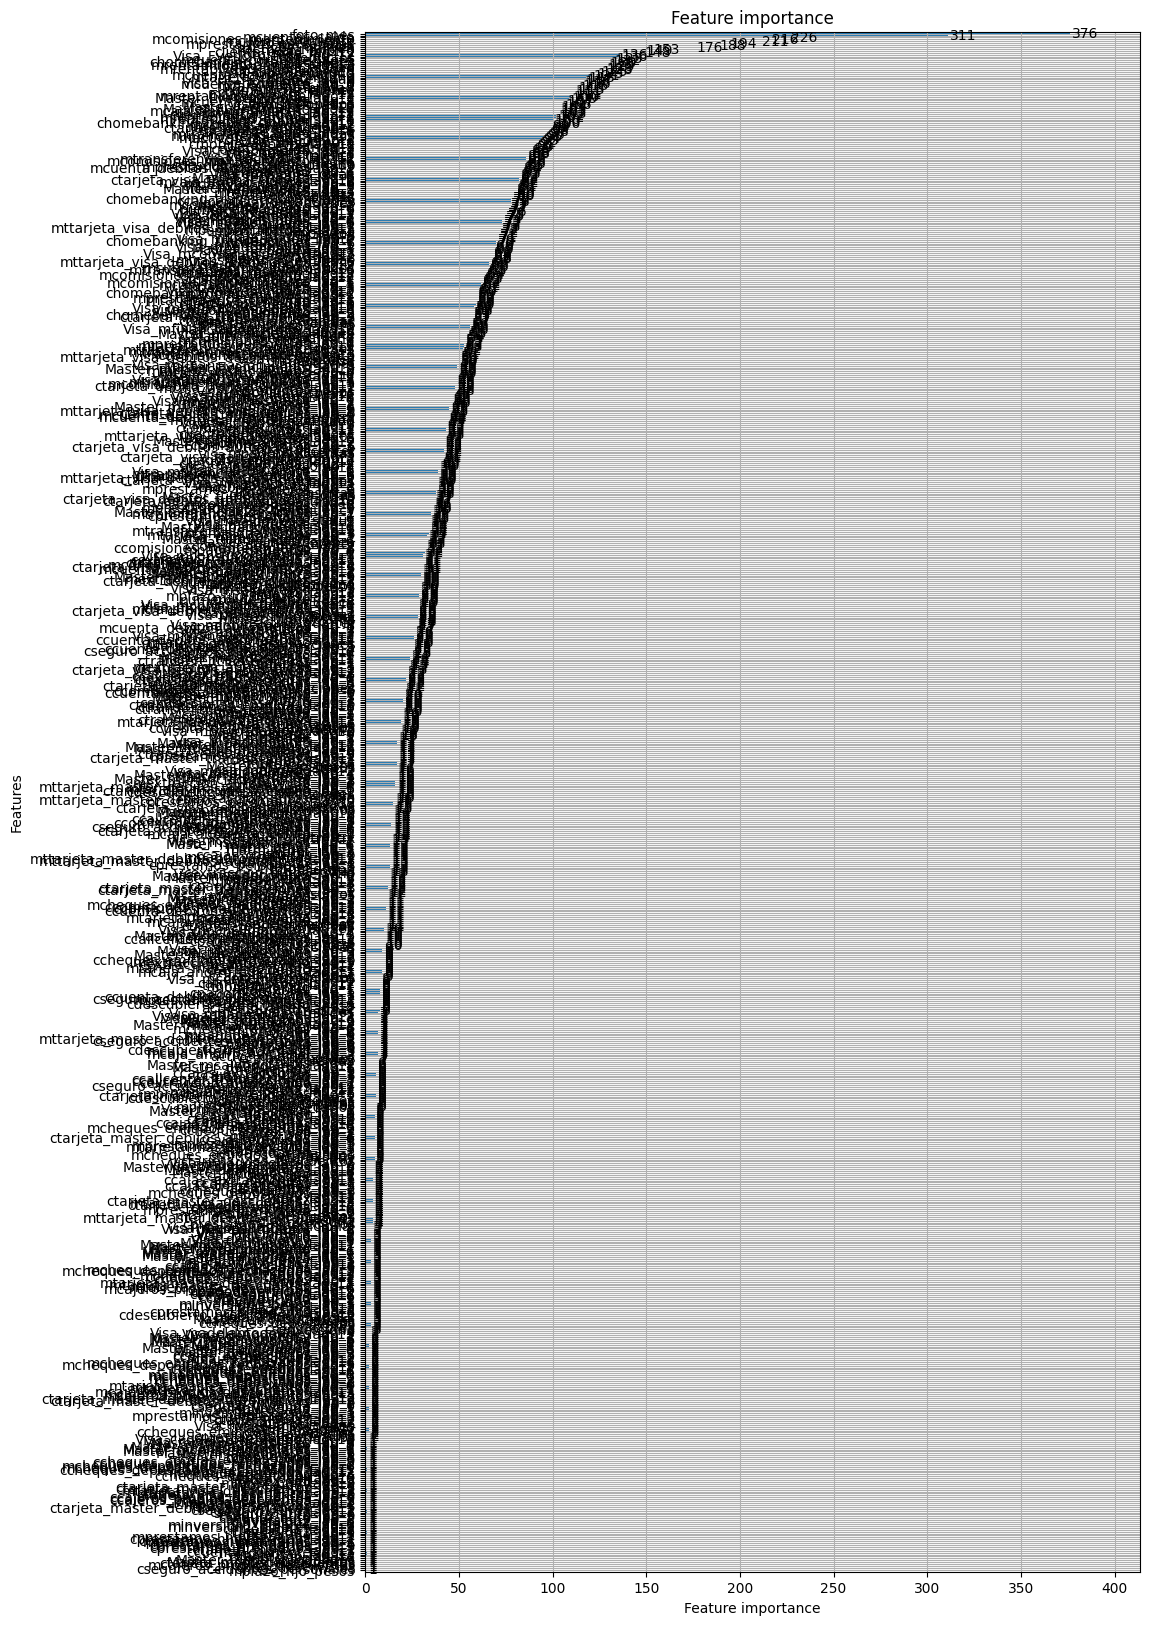

In [23]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [24]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


feature  importance
1                       foto_mes         376
22                mcuentas_saldo         311
72     mcomisiones_mantenimiento         226
16             mcuenta_corriente         216
159               foto_mes_lag_1         211
..                           ...         ...
546            cforex_sell_lag_3           1
543            mforex_buy_lag_12           1
542             mforex_buy_lag_6           1
587   ccheques_depositados_lag_6           1
326  cprestamos_prendarios_lag_3           1

[806 rows x 2 columns]

Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [ ]:
model.save_model(dataset_path + 'lgb_sin_nulos.txt')

Y recuperar el mismo desde ese formato

In [ ]:
model = lgb.Booster(model_file=modelos_path + 'lgb_sin_nulos.txt')

Para realizar nuestra habitual comparación de modelos, partiremos desde el mejor que obtuvimos hasta ahora, el **rf**. Para este fin cargaremos el *binario* que ajustamos un par de clases atrás:

In [ ]:
y_pred_lgm = model.predict(X_test)

Finalmente medimos las ganancias de ambos

Vemos un nuevo salto, tan alto como el del árbol al rf. Será simplemente suerte? veamos que sucede sobre múltiples **LDB**

Otra vez se observa la superioridad del **LGBM**. Veamos que hubiera pasado si elegíamos el mejor del público

Observamos que en 50 **LDBs** solo en un público ganó un **rf**, sin embargo en el 100% de los casos, en el privado ganó un **lgbm**. Asombroso.

Pero el alumno atento, vio que para la selección del mejor modelo no se utilizó ningún punto de corte. Podrá pasar que el mejor punto de corte en entrenamiento, no sea el mejor para un mes en el futuro?

Veamos para esto la curva de ganancia en función de los puntos de corte

In [ ]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()


Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

In [ ]:
mes_test = 202108
X_test = data[data['foto_mes'] == mes_test].drop(columns=['clase_ternaria', 'clase_binaria1', 'clase_binaria2', 'clase_peso'])

pred_v101 = model.predict(X_test)

threshold = 0.025

X_test['Predicted'] = np.where(pred_v101 > threshold, 1, 0)

df = X_test[['numero_de_cliente', 'Predicted']]

df.to_csv(dataset_path + 'modelo_v301.csv', index=False)